In [1]:
import os
import pickle
import numpy as np

def compute_grid_index(coord, grid_size=10):
    """
    Compute the grid index (one-indexed) for a coordinate.
    For example, if grid_size is 10 and x = 45, then grid index = floor(45/10) + 1 = 5.
    """
    return int(coord // grid_size) + 1

def quantized_to_relative_delta(quantized_kp, grid_size=10):
    """
    Convert quantized keypoints into a relative delta sequence.
    
    For each joint in the quantized keypoints array (shape: (n_frames, 42, 3)),
    first compute the grid coordinate for each frame using the quantized (x, y) positions.
    
    Then, for each joint:
      - For frame 0, output the absolute grid cell, e.g. (start_x, start_y).
      - For each subsequent frame i, compute:
             delta_x = grid_x[i] - grid_x[0]
             delta_y = grid_y[0] - grid_y[i]
    
    This yields an array of shape (n_frames, 42, 2).
    
    Parameters:
       quantized_kp (np.ndarray): Array of shape (n_frames, 42, 3), where the first two 
                                  columns are the quantized (x,y) coordinates.
       grid_size (int or float): The grid cell size used during quantization.
    
    Returns:
       delta_seq (np.ndarray): Array of shape (n_frames, 42, 2) containing the delta sequence.
    """
    n_frames, n_joints, _ = quantized_kp.shape
    delta_seq = np.zeros((n_frames, n_joints, 2), dtype=int)
    
    for j in range(n_joints):
        # Extract the (x, y) positions for joint j over all frames.
        joint_xy = quantized_kp[:, j, :2]
        # Compute grid indices for each frame.
        grid_x = np.array([compute_grid_index(x, grid_size) for x in joint_xy[:, 0]])
        grid_y = np.array([compute_grid_index(y, grid_size) for y in joint_xy[:, 1]])
        
        # Define the starting grid for this joint (from frame 0)
        start_x = grid_x[0]
        start_y = grid_y[0]
        
        # For frame 0, store the absolute starting grid position.
        delta_seq[0, j, 0] = start_x
        delta_seq[0, j, 1] = start_y
        
        # For frames 1 to n_frames-1, compute the difference relative to the starting grid.
        for i in range(1, n_frames):
            delta_x = grid_x[i] - start_x
            delta_y = start_y - grid_y[i]  # positive if movement is upward
            delta_seq[i, j, 0] = delta_x
            delta_seq[i, j, 1] = delta_y
    return delta_seq

def process_quantized_to_relative_delta(input_pkl_path, output_pkl_path, grid_size=10):
    """
    Process a quantized pickle file and produce a relative delta sequence version.
    
    The input file is assumed to be a dictionary with keys for each video. For each video,
    the value is a dictionary containing a key 'keypoints' whose value is a NumPy array of shape
    (n_frames, 42, 3) (from the quantized dataset).
    
    For each video, this function computes the relative delta sequence for all 42 joints,
    resulting in an array of shape (n_frames, 42, 2). In this new representation, the first frame
    contains the absolute grid location of the joint action’s starting point (e.g. (4, 3)), and
    subsequent frames are stored as the difference from that starting grid.
    
    The output is saved as a pickle file with the same structure as the input:
      {
         video_key: {
             'keypoints': np.array( shape=(n_frames, 42, 2) )  # the relative delta sequence
         },
         ...
      }
    """
    with open(input_pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    relative_delta_data = {}
    
    for video_key, value in data.items():
        quantized_kp = value['keypoints']  # shape: (n_frames, 42, 3)
        delta_seq = quantized_to_relative_delta(quantized_kp, grid_size=grid_size)
        relative_delta_data[video_key] = {'keypoints': delta_seq}
    
    with open(output_pkl_path, 'wb') as f:
        pickle.dump(relative_delta_data, f)
    
    print(f"Relative delta sequence file saved to: {output_pkl_path}")

# === Example Usage ===

input_quantized_pkl = r'/nas/Dataset/Phoenix/Chingiz/hoenix-2014-hands-quantized.pkl'
output_relative_delta_pkl = r'/nas/Dataset/Phoenix/Chingiz/hoenix-2014-hands-relative-sequence.pkl'

process_quantized_to_relative_delta(input_quantized_pkl, output_relative_delta_pkl, grid_size=10)


Relative delta sequence file saved to: /nas/Dataset/Phoenix/Chingiz/hoenix-2014-hands-relative-sequence.pkl


Using video key: fullFrame-210x260px/train/01April_2010_Thursday_heute_default-0/1/01April_2010_Thursday_heute
(176, 42, 2)
Joint 7 trajectory shape: (176, 2)


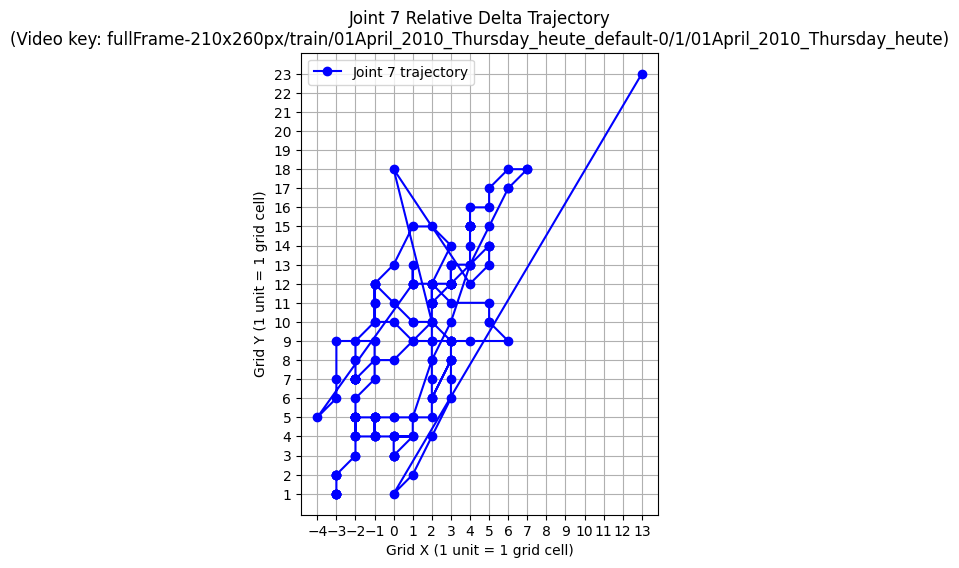

In [9]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
# Path to the relative-sequence pickle file.
pkl_path = r'/nas/Dataset/Phoenix/Chingiz/hoenix-2014-hands-relative-sequence.pkl'

# Load the relative sequence data.
with open(pkl_path, 'rb') as f:
    rel_data = pickle.load(f)

# For demonstration, choose the first video key from the dictionary.
video_key = list(rel_data.keys())[0]    ####   'fullFrame-210x260px/train/01April_2010_Thursday_heute_default-2/1/01April_2010_Thursday_heute' 
print("Using video key:", video_key)

# Extract the relative keypoints.
# Expected shape: (n_frames, 42, 2)
rel_kp = rel_data[video_key]['keypoints']
print(rel_kp.shape)
# --- Select and extract Joint 8 ---
joint_index = 7
joint_traj = rel_kp[:, joint_index, :]  # shape: (n_frames, 2)
print("Joint", joint_index, "trajectory shape:", joint_traj.shape)

# --- Plotting the Trajectory on a 1x1 Grid ---
plt.figure(figsize=(8, 6))
plt.plot(joint_traj[:, 0], joint_traj[:, 1], marker='o', linestyle='-', color='blue', 
         label=f'Joint {joint_index} trajectory')

plt.xlabel('Grid X (1 unit = 1 grid cell)')
plt.ylabel('Grid Y (1 unit = 1 grid cell)')
plt.title(f'Joint {joint_index} Relative Delta Trajectory\n(Video key: {video_key})')

# Set axis ticks at 1 unit intervals.
min_x, max_x = np.min(joint_traj[:, 0]), np.max(joint_traj[:, 0])
min_y, max_y = np.min(joint_traj[:, 1]), np.max(joint_traj[:, 1])
plt.xticks(np.arange(min_x, max_x + 1, 1))
plt.yticks(np.arange(min_y, max_y + 1, 1))

plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()
